### Knapsack Problem


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from qiskit_optimization.applications import Knapsack, Maxcut
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector

from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')

estimator = BackendEstimator(backend=backend, options={'shots': 1000})

In [3]:
from pce import *
from qubo_to_maxcut import *

In [4]:
# the graph
import networkx as nx
import matplotlib.pyplot as plt
def create_graph_from_weight_matrix(w):
    G = nx.Graph()
    n = len(w)

    # Add nodes
    for i in range(n):
        G.add_node(i)

    # Add edges with weights, ignoring zero-weight edges
    for i in range(n):
        for j in range(i + 1, n):
            if w[i, j] != 0:
                G.add_edge(i, j, weight=w[i, j])

    return G

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

### Generating Random Instance

In [5]:
# Parameters for the knapsack problem
num_items = 5
max_weight = 10

# Generate random weights and values for the items

weights = np.random.randint(1, 10, size=num_items)
values = np.random.randint(10, 50, size=num_items)

# Capacity of the knapsack
capacity = int(0.6 * np.sum(weights))

print(f"Weights: {weights}")
print(f"Values: {values}")
print(f"Capacity: {capacity}")

# Create the Knapsack problem
knapsack = Knapsack(values.tolist(), weights.tolist(), capacity)

# Convert the problem to a QuadraticProgram
problem = knapsack.to_quadratic_program()
print(problem.prettyprint())

Weights: [3 6 3 3 2]
Values: [23 48 27 26 11]
Capacity: 10
Problem name: Knapsack

Maximize
  23*x_0 + 48*x_1 + 27*x_2 + 26*x_3 + 11*x_4

Subject to
  Linear constraints (1)
    3*x_0 + 6*x_1 + 3*x_2 + 3*x_3 + 2*x_4 <= 10  'c0'

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



### Exact Solution

In [6]:
# Solve the problem using CplexOptimizer
optimizer = CplexOptimizer()
result = optimizer.solve(problem)

print("Solution:")
print(result.fval)
print(result.x)

Solution:
76.0
[1. 0. 1. 1. 0.]


### Converting to QUBO

In [7]:
# convert problem to a QUBO
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Minimize
 obj: - 8183 x_0 - 16368 x_1 - 8187 x_2 - 8186 x_3 - 5451 x_4
      - 2720 c0@int_slack@0 - 5440 c0@int_slack@1 - 10880 c0@int_slack@2
      - 8160 c0@int_slack@3 + [ 2448 x_0^2 + 9792 x_0*x_1 + 4896 x_0*x_2
      + 4896 x_0*x_3 + 3264 x_0*x_4 + 1632 x_0*c0@int_slack@0
      + 3264 x_0*c0@int_slack@1 + 6528 x_0*c0@int_slack@2
      + 4896 x_0*c0@int_slack@3 + 9792 x_1^2 + 9792 x_1*x_2 + 9792 x_1*x_3
      + 6528 x_1*x_4 + 3264 x_1*c0@int_slack@0 + 6528 x_1*c0@int_slack@1
      + 13056 x_1*c0@int_slack@2 + 9792 x_1*c0@int_slack@3 + 2448 x_2^2
      + 4896 x_2*x_3 + 3264 x_2*x_4 + 1632 x_2*c0@int_slack@0
      + 3264 x_2*c0@int_slack@1 + 6528 x_2*c0@int_slack@2
      + 4896 x_2*c0@int_slack@3 + 2448 x_3^2 + 3264 x_3*x_4
      + 1632 x_3*c0@int_slack@0 + 3264 x_3*c0@int_slack@1
      + 6528 x_3*c0@int_slack@2 + 4896 x_3*c0@int_slack@3 + 1088 x_4^2
      + 1088 x_4*c0@int_slack@0 + 2176 x_4*c0

Now there are two methods we can do:

1. Convert this QUBO into a weighted Max Cut and solve it using PCE with Max Cut Loss function
2. Solve this QUBO with PCE that has the updated QUBO loss function


Let's look at the first step

#### Coverting QUBO to a Weighted Max Cut

In [8]:
linear = qubo.objective.linear.to_array()
quadratic = qubo.objective.quadratic.to_array()

In [9]:
weight_max_cut_qubo = QUBO(quadratic, linear)
weight_max_cut_qubo.linear_to_square()
max_cut_graph = weight_max_cut_qubo.to_maxcut()
print(max_cut_graph)

[[    0.  5666. 11328.  5658.  5660.  3786.  1904.  3808.  7616.  5712.]
 [ 5666.     0.  4896.  2448.  2448.  1632.   816.  1632.  3264.  2448.]
 [11328.  4896.     0.  4896.  4896.  3264.  1632.  3264.  6528.  4896.]
 [ 5658.  2448.  4896.     0.  2448.  1632.   816.  1632.  3264.  2448.]
 [ 5660.  2448.  4896.  2448.     0.  1632.   816.  1632.  3264.  2448.]
 [ 3786.  1632.  3264.  1632.  1632.     0.   544.  1088.  2176.  1632.]
 [ 1904.   816.  1632.   816.   816.   544.     0.   544.  1088.   816.]
 [ 3808.  1632.  3264.  1632.  1632.  1088.   544.     0.  2176.  1632.]
 [ 7616.  3264.  6528.  3264.  3264.  2176.  1088.  2176.     0.  3264.]
 [ 5712.  2448.  4896.  2448.  2448.  1632.   816.  1632.  3264.     0.]]


Make the Max Cut LP 

In [10]:
max_cut = Maxcut(max_cut_graph)
problem_max_cut = max_cut.to_quadratic_program()
print(problem_max_cut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 51138 x_0 + 25250 x_1 + 45600 x_2 + 25242 x_3 + 25244 x_4 + 17386 x_5
      + 8976 x_6 + 17408 x_7 + 32640 x_8 + 25296 x_9 + [ - 22664 x_0*x_1
      - 45312 x_0*x_2 - 22632 x_0*x_3 - 22640 x_0*x_4 - 15144 x_0*x_5
      - 7616 x_0*x_6 - 15232 x_0*x_7 - 30464 x_0*x_8 - 22848 x_0*x_9
      - 19584 x_1*x_2 - 9792 x_1*x_3 - 9792 x_1*x_4 - 6528 x_1*x_5
      - 3264 x_1*x_6 - 6528 x_1*x_7 - 13056 x_1*x_8 - 9792 x_1*x_9
      - 19584 x_2*x_3 - 19584 x_2*x_4 - 13056 x_2*x_5 - 6528 x_2*x_6
      - 13056 x_2*x_7 - 26112 x_2*x_8 - 19584 x_2*x_9 - 9792 x_3*x_4
      - 6528 x_3*x_5 - 3264 x_3*x_6 - 6528 x_3*x_7 - 13056 x_3*x_8
      - 9792 x_3*x_9 - 6528 x_4*x_5 - 3264 x_4*x_6 - 6528 x_4*x_7
      - 13056 x_4*x_8 - 9792 x_4*x_9 - 2176 x_5*x_6 - 4352 x_5*x_7
      - 8704 x_5*x_8 - 6528 x_5*x_9 - 2176 x_6*x_7 - 4352 x_6*x_8 - 3264 x_6*x_9
      - 8704 x_7*x_8 - 6528 x_7*x_9 - 13056 x_8*x_9 ]/2
Subjec

Let's visualize the graph

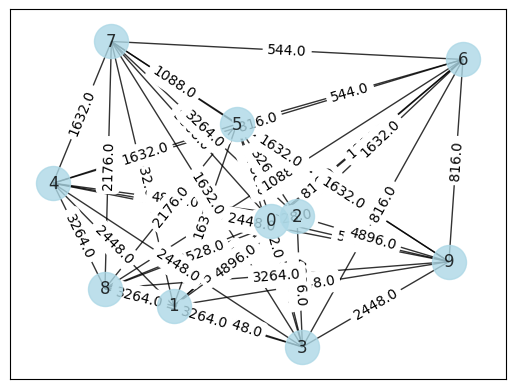

In [11]:
graph = create_graph_from_weight_matrix(max_cut_graph)
draw_graph(graph, "lightblue", nx.spring_layout(graph))

In [12]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(problem_max_cut.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,problem_max_cut.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 4 qubits using 10 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXII', 'XIXI', 'XIIX', 'IXXI', 'IXIX', 'IIXX', 'YYII', 'YIYI', 'YIIY', 'IYYI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


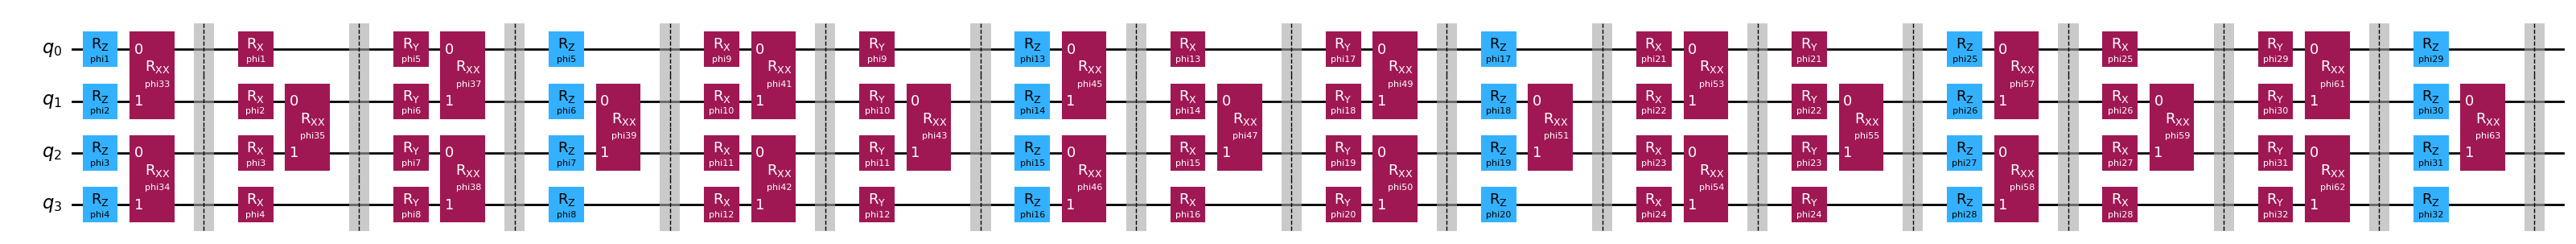

In [13]:
depth = 2 * num_qubits
# num_nodes = graph.number_of_nodes()
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [14]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                qp = problem_max_cut,
                                graph=graph,
                                num_qubits=num_qubits,
                                k=k,
                                max_cut_graph=max_cut_graph,
                                method='exact', 
                                loss_method='maxcut',
                                multi_op=False)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut


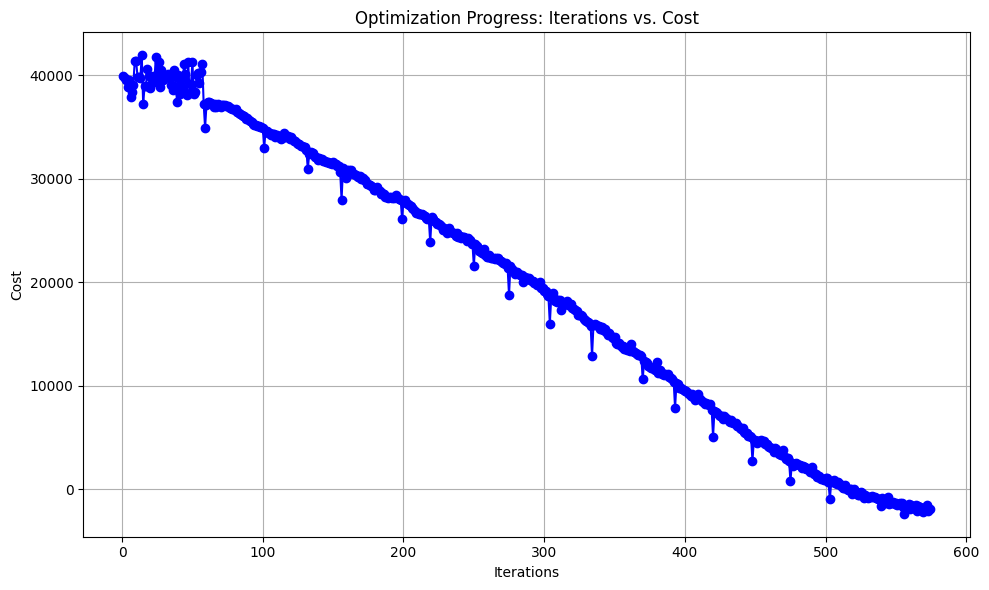

In [15]:
maxiter = 30
from qiskit_algorithms.optimizers import COBYLA,SLSQP,POWELL
optimizer = SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


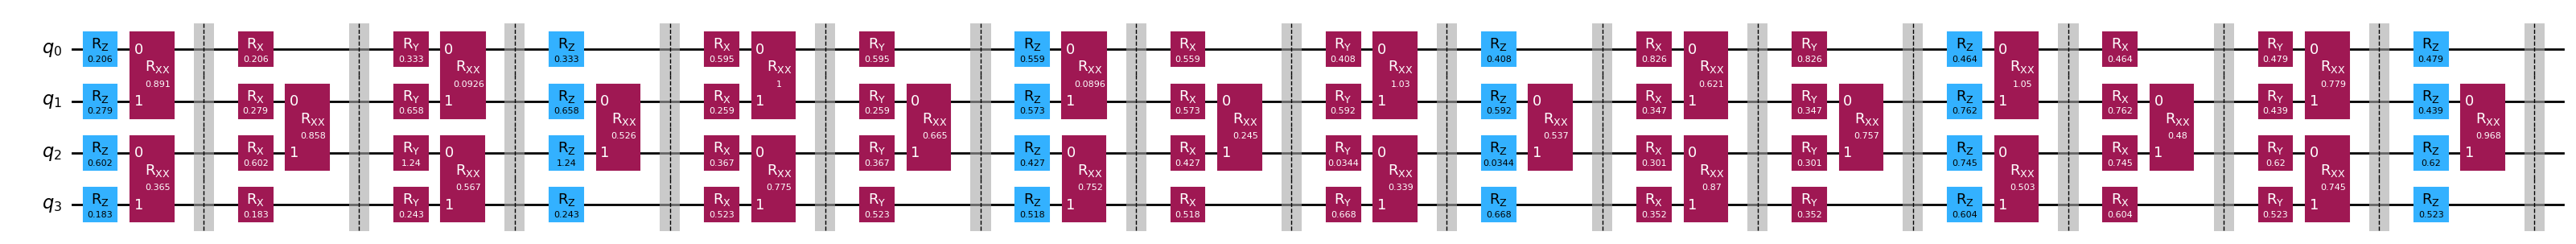

In [16]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [17]:
psi_final = Statevector(final_ansatz)

In [18]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
max_cut_utility = MaxCutUtility(max_cut_graph)
initial_score, max_cut_solution_pce = max_cut_utility.evaluate_initial_score(psi_final, pauli_strings)
print(f"Initial score: {initial_score}")
print(f"Max cut solution: {max_cut_solution_pce}")

Initial score: 78088.0
Max cut solution: [1, 0, 0, 0, 0, 1, 0, 0, 1, 1]


In [19]:
# convert to QUBO cost
qubo_solution_string = max_cut_utility.max_cut_to_qubo_solution(max_cut_solution_pce)
# get the qubo cost from the string
qubo_cost = qubo.objective.evaluate(qubo_solution_string)
print(f"QUBO cost: {qubo_cost}")
print(f"Qubo Solution Bitstring: {qubo_solution_string}")

QUBO cost: 125.0
Qubo Solution Bitstring: [0, 0, 0, 0, 1, 0, 0, 1, 1]


In [20]:

result_initial = converter.interpret(qubo_solution_string)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 11.0
Initial Knapsack solution          : [0. 0. 0. 0. 1.]
Initial Knapsack solution feasible : True


### Bit Swap

In [21]:
optimized_bitstring, final_cost = max_cut_utility.bit_swap_search(qubo, bitstring=qubo_solution_string)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: 125.0
Bit flip: Improved solution by flipping bit 5: Cost = -11.0
Multi-bit flip: Improved solution by flipping bits (0, 8): Cost = -34.0
Multi-bit flip: Improved solution by flipping bits (1, 4, 7): Cost = -71.0
Bit swap: Improved solution by swapping bits 0 and 2: Cost = -75.0
Final best cost: -75.0
Optimized bitstring: [0, 1, 1, 0, 0, 1, 0, 0, 0]
Final cost: -75.0


In [22]:

result_initial = converter.interpret(optimized_bitstring)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 75.0
Initial Knapsack solution          : [0. 1. 1. 0. 0.]
Initial Knapsack solution feasible : True


### QUBO Loss 

The second method is making use of PCE with QUBO loss function

In [23]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(qubo.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,qubo.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 3 qubits using 9 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXI', 'XIX', 'IXX', 'YYI', 'YIY', 'IYY', 'ZZI', 'ZIZ', 'IZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


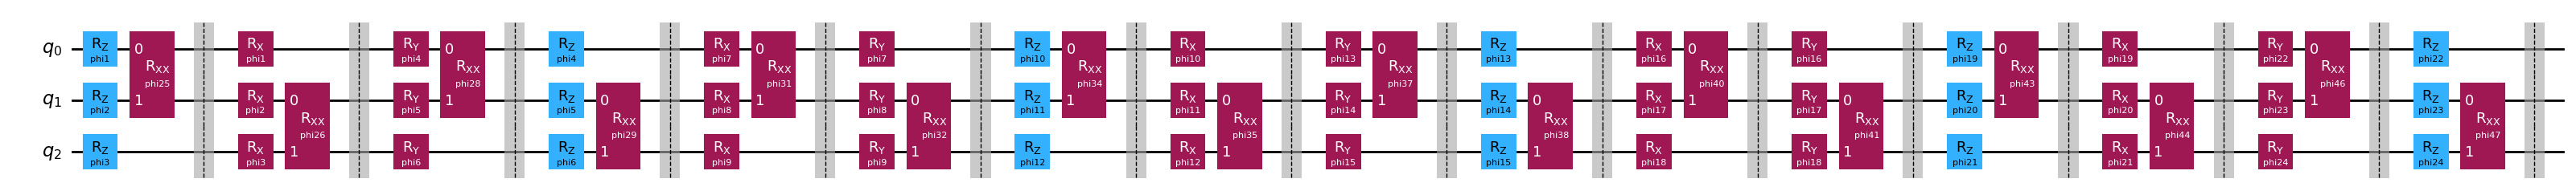

In [24]:
depth = 8
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [25]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                num_qubits=num_qubits,
                                k=k,
                                method='exact', 
                                loss_method='qubo',
                                qubo=qubo,
                                multi_op=True,
                                steps = 5)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut



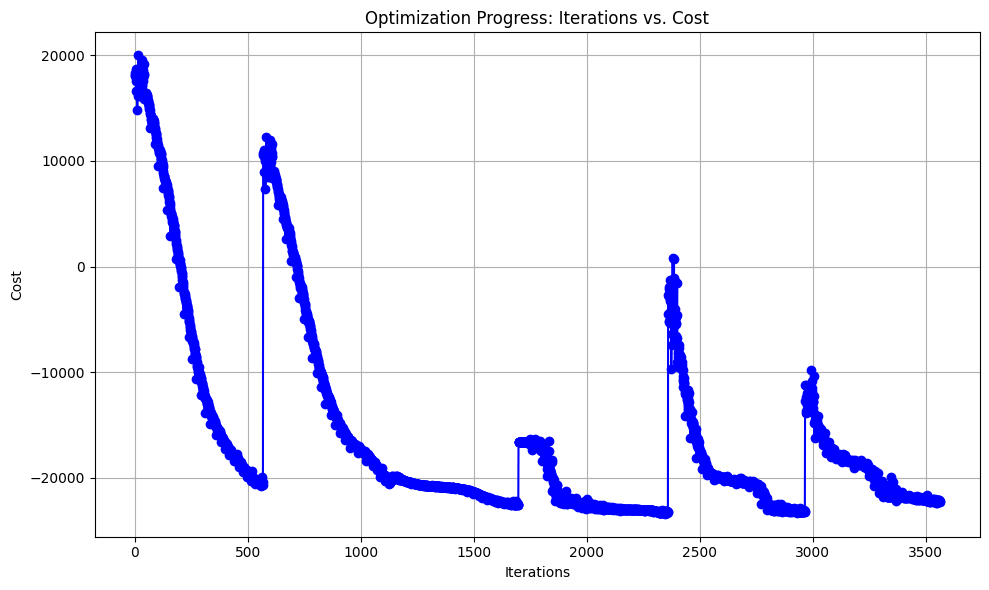

Best QUBO cost: 30465.0
QUBO cost: 34681.0
No improvement detected.
No improvement in round 6.
Random restart triggered due to stagnation.
Consecutive no-improvement rounds: 5. Rounds remaining before stopping: 0.

Optimization complete.
Best QUBO cost: 30465.0


In [26]:
maxiter = 30
from qiskit_algorithms.optimizers import SLSQP
optimizer =SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


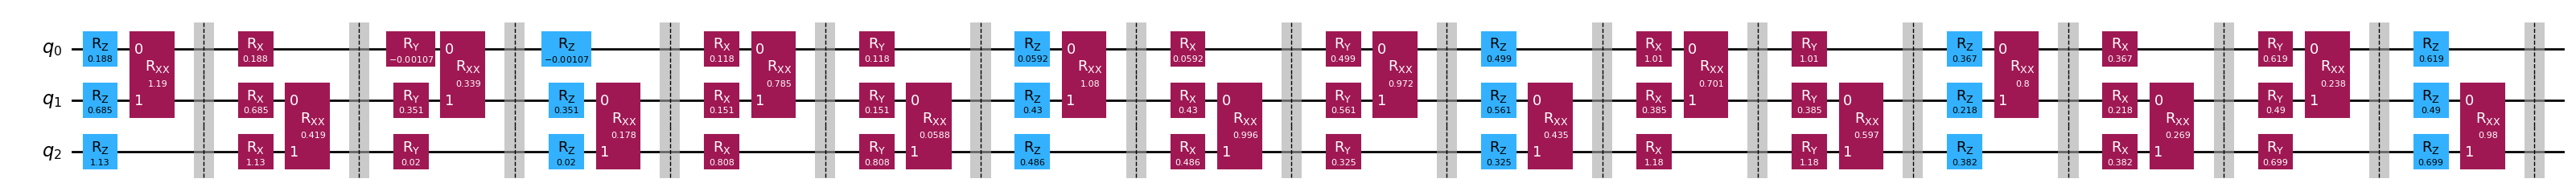

In [27]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [28]:
psi_final = Statevector(final_ansatz)

In [29]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
qubo_utility = QUBOUtility()
qubo_bitstring = qubo_utility.evaluate_sign_function(psi_final, pauli_strings)
qubo_cost = qubo.objective.evaluate(qubo_bitstring)

print(qubo_bitstring)
print(qubo_cost)

[1, 1, 1, 1, 1, 1, 0, 1, 1]
30465.0


In [30]:
result_initial = converter.interpret(qubo_bitstring)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 135.0
Initial Knapsack solution          : [1. 1. 1. 1. 1.]
Initial Knapsack solution feasible : False


In [31]:
optimized_bitstring, final_cost = qubo_utility.bit_swap_search(qubo, bitstring=qubo_bitstring)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: 30465.0
Bit flip: Improved solution by flipping bit 0: Cost = 19472.0
Bit flip: Improved solution by flipping bit 1: Cost = 4832.0
Bit flip: Improved solution by flipping bit 2: Cost = 1187.0
Bit flip: Improved solution by flipping bit 3: Cost = -11.0
Multi-bit flip: Improved solution by flipping bits (0, 8): Cost = -34.0
Multi-bit flip: Improved solution by flipping bits (1, 4, 7): Cost = -71.0
Bit swap: Improved solution by swapping bits 0 and 2: Cost = -75.0
Final best cost: -75.0
Optimized bitstring: [0, 1, 1, 0, 0, 1, 0, 0, 0]
Final cost: -75.0


In [32]:

result_initial = converter.interpret(optimized_bitstring)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 75.0
Initial Knapsack solution          : [0. 1. 1. 0. 0.]
Initial Knapsack solution feasible : True
